In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LightSource

In [2]:
# Settings
b = 0.05
dx = 0.01
dy = 0.01
dt = 10**(-4)
T = [0,0.05,0.5]

x = np.linspace(0,1,int(1/dx)+1)
y = np.linspace(0,1,int(1/dy)+1)

        
# Compute coeff
c1 = 1-2*b*dt/dx**2-2*b*dt/dy**2
c2 = np.sin(2*np.pi*x)*dt/2/dx+b*dt/dx**2
c3 = -np.sin(2*np.pi*x)*dt/2/dx+b*dt/dx**2
c4 = np.cos(2*np.pi*y)*dt/2/dy+b*dt/dy**2
c5 = -np.cos(2*np.pi*y)*dt/2/dy+b*dt/dy**2

In [3]:
# FTCS
U_result = []
for t in T:
    # Initial Condition
    U = np.zeros((len(x),len(y)))
    for j in range(len(x)):
        for l in range(len(y)):
            U[j,l] = np.cos(2*np.pi*x[j])*np.cos(2*np.pi*y[l])
            
    N = int(t/dt)
    for n in range(N):
        U_new = np.zeros((len(x)-1,len(y)-1))
        temp = U[:-1,:-1]
        for j in range(len(x)-1):
            for l in range(len(y)-1):
                if l==len(y)-2 and j<len(x)-2:
                    U_new[j,l] = c1*temp[j,l]+c2[j]*temp[j-1,l]+c3[j]*temp[j+1,l]+c4[l]*temp[j,l-1]+c5[l]*U[j,l+1]
                elif j==len(x)-2 and l<len(y)-2:
                    U_new[j,l] = c1*temp[j,l]+c2[j]*temp[j-1,l]+c3[j]*U[j+1,l]+c4[l]*temp[j,l-1]+c5[l]*temp[j,l+1]
                elif j==len(x)-2 and l==len(y)-2:
                    U_new[j,l] = c1*U[j,l]+c2[j]*U[j-1,l]+c3[j]*U[j+1,l]+c4[l]*U[j,l-1]+c5[l]*U[j,l+1]
                else:
                    U_new[j,l] = c1*temp[j,l]+c2[j]*temp[j-1,l]+c3[j]*temp[j+1,l]+c4[l]*temp[j,l-1]+c5[l]*temp[j,l+1]

        U[:-1,:-1] = U_new
        # Boundary Condition
        U[:,-1] = U[:,0]
        U[-1,:] = U[0,:]
        
    U_result.append(U)

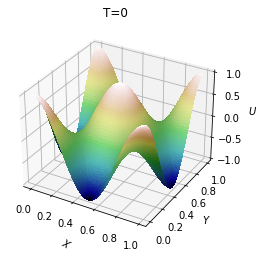

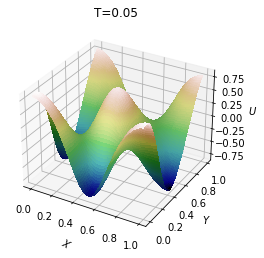

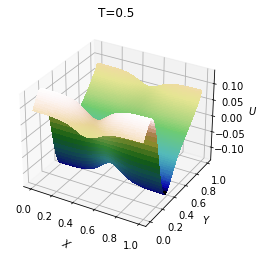

In [4]:
# plot 3D result
for t,U in zip(T,U_result):
    Y, X = np.meshgrid(x[:-1],y[:-1])
    Z = U[:-1,:-1]

    fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

    ls = LightSource(270, 45)
    rgb = ls.shade(Z, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=rgb, linewidth=0, antialiased=False, shade=False)

    ax.set_xlabel('$X$', rotation=150)
    ax.set_ylabel('$Y$')
    ax.set_zlabel('$U$')
    plt.title('T='+str(t))
    plt.show()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LightSource

In [2]:
# Settings
b = 0.05
dx = 0.01
dy = 0.01
dt = 0.001
T = [0,0.05,0.5]

x = np.linspace(0,1,int(1/dx)+1)
y = np.linspace(0,1,int(1/dy)+1)

# Step 1 constants
a1 = 0.5*b*dt/dx**2+0.25*np.sin(2*np.pi*x)*dt/dx
b1 = 1+b*dt/dx**2*np.ones(len(x))
c1 = 0.5*b*dt/dx**2-0.25*np.sin(2*np.pi*x)*dt/dx
r11 = -0.25*np.cos(2*np.pi*y)*dt/dy
r12 = 0.5*b*dt/dy**2
alpha1 = np.zeros(len(x))
alpha1[0] = b1[0]
for i in range(1,len(x)-1):
    alpha1[i] = b1[i]-(a1[i]*c1[i-1])/alpha1[i-1]

# Step 2 constants
a2 = 0.5*b*dt/dy**2+0.25*np.cos(2*np.pi*y)*dt/dy
b2 = 1+b*dt/dy**2*np.ones(len(y))
c2 = 0.5*b*dt/dy**2-0.25*np.cos(2*np.pi*y)*dt/dy
r21 = -0.25*np.sin(2*np.pi*x)*dt/dx
r22 = 0.5*b*dt/dx**2
alpha2 = np.zeros(len(y))
alpha2[0] = b2[0]
for i in range(1,len(y)-1):
    alpha2[i] = b2[i]-(a2[i]*c2[i-1])/alpha2[i-1]

In [3]:
# Thomas Algorithm
U_result = []
for t in T:
    # Initial Condition
    U = np.zeros((len(x),len(y)))
    for j in range(len(x)):
        for l in range(len(y)):
            U[j,l] = np.cos(2*np.pi*x[j])*np.cos(2*np.pi*y[l])
            
    N = int(t/dt)
    for n in range(N):
        # Step 1
        ## prepare
        U_mid = np.zeros((len(x),len(y)))
        temp1_mtx = U[:-1,:-1]
        D1 = np.zeros((len(x),len(y)))
        for j in range(len(x)-1):
            temp1 = temp1_mtx[j,:]
            D1[j,:-2] = temp1[:-1]+r11[:-2]*(temp1[1:]-np.roll(temp1,1)[:-1])+r12*(np.roll(temp1,1)[:-1]-2*temp1[:-1]+temp1[1:])
        D1[:,-2] = U[:,-2]+r11[-2]*(U[:,-1]-U[:,-3])+r12*(U[:,-3]-2*U[:,-2]+U[:,-1])
        
        for l in range(len(y)-1):
            d1 = D1[:,l]
            d1[0] = d1[0]+a1[0]*U[-2,l]
            d1[-2] = d1[-2]+c1[-2]*U[-1,l]
            s1 = np.zeros(len(x))
            s1[0] = d1[0]
            
            ## forward elimination
            for i in range(1,len(s1)-1):
                s1[i] = d1[i]+(a1[i]*s1[i-1])/alpha1[i-1]
                
            ## backward subsititution
            U_mid[-2,l] = s1[-2]/alpha1[-2]
            for i in range(len(x)-3,-1,-1):
                U_mid[i,l] = (s1[i]+c1[i]*U_mid[i+1,l])/alpha1[i]
                
            U_mid[-1,l] = U_mid[0,l]
        U_mid[:,-1] = U_mid[:,0]
        
        #Step 2
        ## prepare
        U_new = np.zeros((len(x),len(y)))
        temp2_mtx = U_mid[:-1,:-1]
        D2 = np.zeros((len(x),len(y)))
        for l in range(len(y)-1):
            temp2 = temp2_mtx[:,l]
            D2[:-2,l] = temp2[:-1]+r21[:-2]*(temp2[1:]-np.roll(temp2,1)[:-1])+r22*(np.roll(temp2,1)[:-1]-2*temp2[:-1]+temp2[1:])
        D2[-2,:] = U_mid[-2,:]+r21[-2]*(U_mid[-1,:]-U_mid[-3,:])+r22*(U_mid[-3,:]-2*U_mid[-2,:]+U_mid[-1,:])
        
        for j in range(len(x)-1):
            d2 = D2[j,:]
            d2[0] = d2[0]+a2[0]*U_mid[j,-2]
            d2[-2] = d2[-2]+c2[-2]*U_mid[j,-1]
            s2 = np.zeros(len(y))
            s2[0] = d2[0]
            
            ## forward elimination
            for i in range(1,len(s1)-1):
                s2[i] = d2[i]+(a2[i]*s2[i-1])/alpha2[i-1]
                
            ## backward elimination
            U_new[j,-2] = s2[-2]/alpha2[-2]
            for i in range(len(y)-3,-1,-1):
                U_new[j,i] = (s2[i]+c2[i]*U_new[j,i+1])/alpha2[i]
                
            U_new[j,-1] = U_new[j,0]
        U_new[-1,:] = U_new[0,:]
        
        U = U_new
        
    U_result.append(U)

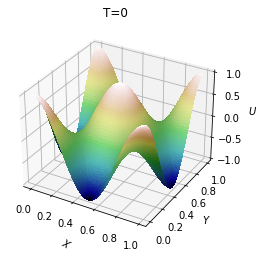

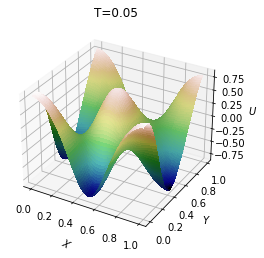

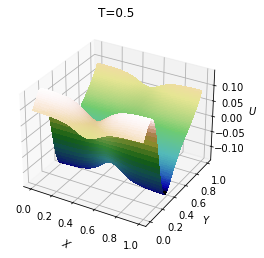

In [4]:
# plot 3D result
for t,U in zip(T,U_result):
    Y, X = np.meshgrid(x[:-1],y[:-1])
    Z = U[:-1,:-1]

    fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

    ls = LightSource(270, 45)
    rgb = ls.shade(Z, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=rgb, linewidth=0, antialiased=False, shade=False)

    ax.set_xlabel('$X$', rotation=150)
    ax.set_ylabel('$Y$')
    ax.set_zlabel('$U$')
    plt.title('T='+str(t))
    plt.show()

After comparing two results with different scheme, we found that they are nearly get the same results, showing that both scheme converges, however, the second scheme (ADI) is far more faster than the previous one (FTCS) since there is stronger restriction on stability condition for FTCS scheme. It's a better choice for ADI scheme on solving this equation.